# Batch Effect detection class

In [1]:
!pip -q install ./../../BatchDetect

## Reading metadata

let's use a subset of data for now

In [5]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import numpy as np
import pandas as pd
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# create metadata dataframe from clini_table and folder structure
clini_table = pd.read_excel('/lustre/groups/peng/datasets/histology_data/clini_tables/TCGA-CRC-DX_CLINI.xlsx')

# metadata with columns: file, label (MSI-H), submission site
base_dir = Path('/lustre/groups/shared/users/peng_marr/BatchDetect/')
patch_list = list(base_dir.glob('BatchDetectTCGA/*/*/*.jpeg'))
print('Number of patches:', len(patch_list))

submission_site = [patch.parent.parent.name for patch in patch_list]
label = [clini_table.isMSIH[clini_table['PATIENT'] == patch.parent.name[:12]].item() for patch in patch_list]
metadata = pd.DataFrame(list(zip(patch_list, label, submission_site)), columns=['file', 'label', 'dataset'])

Number of patches: 5630


In [6]:
np.unique(np.array(submission_site), return_counts=True)

(array(['A6', 'AA', 'AZ', 'CM', 'D5', 'DM', 'G4'], dtype='<U2'),
 array([1050, 1120,  450,  850,  790,  510,  860]))

In [7]:
metadata

,file,label,dataset
0,/lustre/groups/shared/users/peng_marr/BatchDet...,nonMSIH,AZ
1,/lustre/groups/shared/users/peng_marr/BatchDet...,nonMSIH,AZ
2,/lustre/groups/shared/users/peng_marr/BatchDet...,nonMSIH,AZ
3,/lustre/groups/shared/users/peng_marr/BatchDet...,nonMSIH,AZ
4,/lustre/groups/shared/users/peng_marr/BatchDet...,nonMSIH,AZ
...,...,...,...
5625,/lustre/groups/shared/users/peng_marr/BatchDet...,NaN,A6
5626,/lustre/groups/shared/users/peng_marr/BatchDet...,NaN,A6
5627,/lustre/groups/shared/users/peng_marr/BatchDet...,NaN,A6
5628,/lustre/groups/shared/users/peng_marr/BatchDet...,NaN,A6


## Features

In [8]:
from batchdetect.image import automatic_feature_extraction

df_features_path = base_dir / 'automatic_features.csv'

if df_features_path.exists():
    df_features = pd.read_csv(df_features_path)
else:
    df_features = automatic_feature_extraction(metadata)
    df_features.to_csv(df_features_path)

100%|██████████| 5630/5630 [01:19<00:00, 70.79it/s]


In [9]:
df_features

,mean_intensity_Ch1,std_intensity_Ch1,kurtosis_intensity_Ch1,skew_intensity_Ch1,min_intensity_Ch1,max_intensity_Ch1,shannon_entropy_Ch1,contrast_Ch1,dissimilarity_Ch1,homogeneity_Ch1,...,skew_intensity_Ch3,min_intensity_Ch3,max_intensity_Ch3,shannon_entropy_Ch3,contrast_Ch3,dissimilarity_Ch3,homogeneity_Ch3,ASM_Ch3,energy_Ch3,correlation_Ch3
0,174.141162,42.879753,-0.564111,-0.168115,26,-1,7.385557,2342.028030,36.210247,0.034210,...,0.351223,48,-1,7.258903,1888.050600,32.677769,0.036539,0.000075,0.008638,0.413053
1,166.591257,49.287548,-0.711537,-0.323687,22,-1,7.556028,2859.637215,40.754249,0.029662,...,0.173680,50,-1,7.369778,1775.041874,32.347678,0.035360,0.000065,0.008081,0.500311
2,176.348162,47.188270,-0.598370,-0.423457,13,-1,7.464198,2406.733408,36.372864,0.036004,...,-0.021715,34,-1,7.431500,2069.052067,34.090267,0.037385,0.000064,0.007972,0.507436
3,185.270310,44.924914,-0.318896,-0.609945,22,-1,7.353201,1986.016552,32.257991,0.043293,...,-0.151450,51,-1,7.319402,1632.396560,29.860783,0.043752,0.000081,0.009017,0.555943
4,186.269538,43.703226,-0.315919,-0.626630,28,-1,7.307609,2099.422918,33.241337,0.043888,...,-0.183336,50,-1,7.305133,1738.680534,30.868621,0.042827,0.000083,0.009112,0.526963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,129.340723,58.561714,-0.928393,0.350721,0,-1,7.671134,1949.319216,31.665813,0.051503,...,0.760921,30,-1,7.273056,1005.277091,22.937365,0.060228,0.000125,0.011199,0.766923
5626,120.678192,44.968515,-0.120511,0.358228,0,-1,7.484169,2028.791675,34.426035,0.033065,...,0.759254,33,-1,6.949326,953.553352,23.629957,0.045186,0.000130,0.011412,0.526318
5627,175.794644,49.586978,0.574906,-0.994820,0,-1,7.454071,2875.943235,39.062408,0.031504,...,-0.132043,27,-1,7.298832,1630.926512,30.864310,0.036001,0.000073,0.008567,0.460528
5628,132.795248,53.648052,-0.847807,-0.182961,0,-1,7.705552,2539.517303,37.287625,0.031758,...,0.014586,23,-1,7.337107,1358.176609,27.649910,0.040719,0.000076,0.008728,0.572031


considering that one of the datasets include four channels, we need to remove it from the dataframe for a fair comaparison

In [5]:
col_index = ~df_features.columns.str.contains("Ch4")

df_features = df_features.loc[:,col_index]

## Let's see if there is a batch effect in the data

In [6]:
from batchdetect.batchdetect import BatchDetect

bd = BatchDetect(metadata.loc[:,["label","dataset"]], df_features)

In [7]:
df_features

,mean_intensity_Ch1,std_intensity_Ch1,kurtosis_intensity_Ch1,skew_intensity_Ch1,min_intensity_Ch1,max_intensity_Ch1,shannon_entropy_Ch1,contrast_Ch1,dissimilarity_Ch1,homogeneity_Ch1,...,skew_intensity_Ch3,min_intensity_Ch3,max_intensity_Ch3,shannon_entropy_Ch3,contrast_Ch3,dissimilarity_Ch3,homogeneity_Ch3,ASM_Ch3,energy_Ch3,correlation_Ch3
0,221.348424,38.869620,6.173398,-2.117118,38,-1,5.616187,282.292190,8.488271,0.324890,...,-0.661960,85,-42,5.625311,102.373430,6.286486,0.274772,0.004587,0.067729,0.908743
1,218.871266,47.041004,2.541209,-1.651151,38,-1,5.700606,416.400931,8.943328,0.382714,...,-0.574149,88,-37,5.534231,110.276553,5.923781,0.313051,0.007836,0.088520,0.925494
2,220.574143,40.461620,5.028210,-2.011288,39,-1,5.964605,266.353308,7.870399,0.303087,...,-0.743139,87,-44,5.592030,78.004912,5.431025,0.282668,0.003747,0.061213,0.929077
3,223.097153,40.062907,5.323639,-2.073523,39,-1,5.875051,269.272099,8.528235,0.308668,...,-0.847833,89,-42,5.573709,100.129678,6.206084,0.283994,0.006122,0.078245,0.914170
4,221.729324,36.628026,6.420070,-2.111285,44,-1,5.693728,212.324720,7.978947,0.269753,...,-0.533031,105,-40,5.672700,61.361207,5.355543,0.241547,0.002609,0.051074,0.929227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13165,206.093268,51.810560,0.006388,-1.025558,43,-1,6.521768,287.787740,10.267054,0.177391,...,-1.145525,69,-1,6.148758,226.198677,8.695610,0.208439,0.004100,0.064032,0.942158
13166,218.421586,44.442455,1.344080,-1.491533,47,-1,6.262727,212.483559,7.829235,0.197991,...,-1.453615,41,-1,5.689594,232.493056,7.278048,0.289067,0.022276,0.149251,0.922148
13167,191.498565,47.465164,1.306695,-1.467778,43,-1,6.809583,208.443107,9.437291,0.140440,...,-1.235965,61,-1,6.713047,173.126362,8.514858,0.149628,0.000747,0.027340,0.952829
13168,215.007595,45.701505,0.491006,-1.188052,74,-1,6.160253,180.595995,8.553961,0.234335,...,-1.417671,83,-1,5.516283,235.555224,8.861172,0.355046,0.071546,0.267481,0.933210


# visualizations

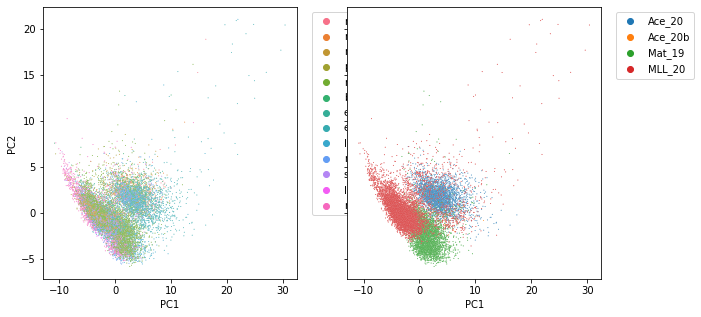

In [8]:
bd.low_dim_visualization("pca")

/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/icb/sayedali.boushehri/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


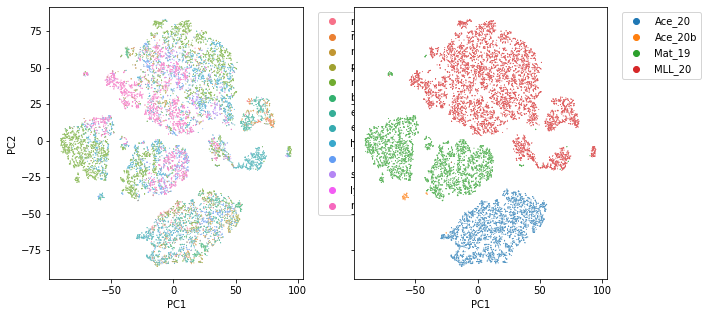

In [9]:
bd.low_dim_visualization("tsne")

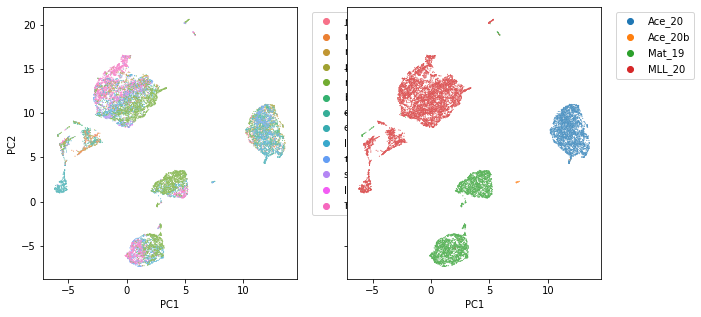

In [10]:
bd.low_dim_visualization("umap")

# Anova test of principal components vs. labels

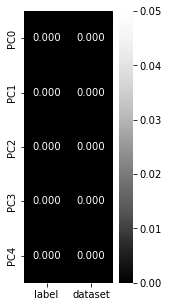

In [11]:
bd.prince_plot()

## classification test of  RF vs a random classifier

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   46.8s finished


comparing label MannwhitneyuResult(statistic=0.0, pvalue=7.066071930388932e-18)
comparing dataset MannwhitneyuResult(statistic=0.0, pvalue=7.901067802071477e-19)


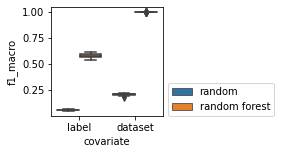

In [12]:
bd.classification_test(scorer="f1_macro")